In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

Data preprocessing

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/titanic')
else:
    import zipfile
    from kaggle.api.kaggle_api_extended import KaggleApi

    path = Path('titanic')
    api = KaggleApi()
    api.authenticate()
    api.competition_download_cli('titanic')
    zipfile.ZipFile(f'{path}.zip').extractall(path)


df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [4]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [5]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [6]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

Before we create a Random Forest or Gradient Boosting Machine, we'll first need to learn how to create a decision tree, from which both of these models are built.

And to create a decision tree, we'll first need to create a binary split, since that's what a decision tree is built from.

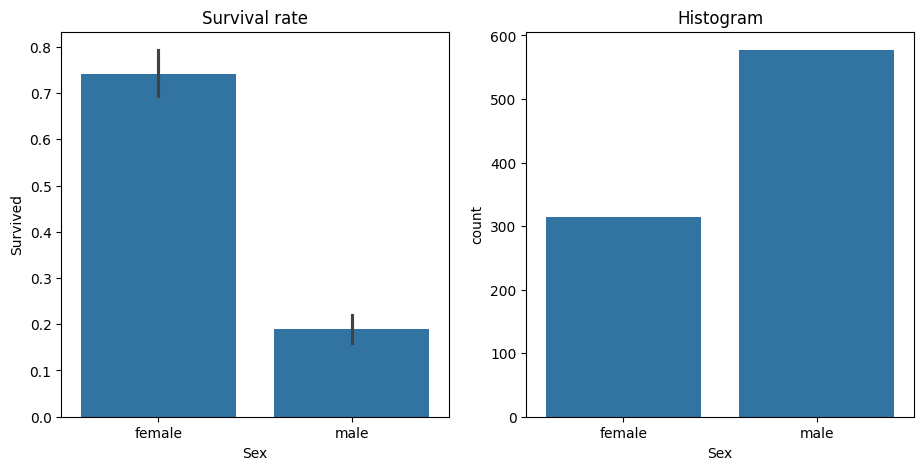

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

We could create a very simple "model" which simply says that all females survive, and no males do. To do so, we better first split our data into a training and validation set, to see how accurate this approach turns out to be:

In [10]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

Now we can create our independent variables (the x variables) and dependent (the y variable):

In [12]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

Here's the predictions for our extremely simple model, where female is coded as 0:

In [15]:
preds = val_xs.Sex==0

We'll use mean absolute error to measure how good this model is:

In [18]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

- here's an example of how we could look at LogFare

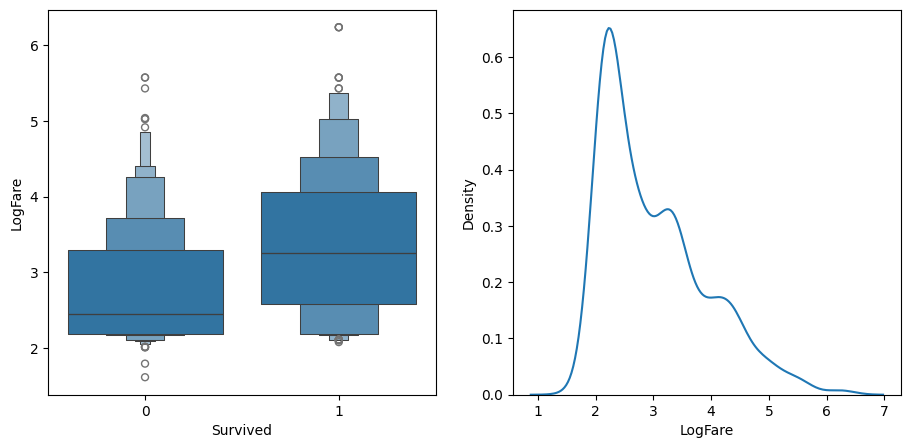

In [19]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

The boxenplot above shows quantiles of LogFare for each group of Survived==0 and Survived==1. It shows that the average LogFare for passengers that didn't survive is around 2.5, and for those that did it's around 3.2

In [20]:
preds = val_xs.LogFare>2.7

In [21]:
mean_absolute_error(val_y, preds)

0.336322869955157

This is quite a bit less accurate than our model that used Sex as the single binary split.

Ideally, we'd like some way to try more columns and breakpoints more easily. We could create a function that returns how good our model is, in order to more quickly try out a few different splits. We'll create a score function to do this. Instead of returning the mean absolute error, we'll calculate a measure of impurity -- that is, how much the binary split creates two groups where the rows in a group are each similar to each other, or dissimilar.

We can measure the similarity of rows inside a group by taking the standard deviation of the dependent variable. If it's higher, then it means the rows are more different to each other. We'll then multiply this by the number of rows, since a bigger group as more impact than a smaller group:

In [22]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [23]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

For instance, here's the impurity score for the split on Sex:

In [24]:
score(trn_xs["Sex"], trn_y, 0.5)

np.float64(0.40787530982063946)

In [27]:
score(trn_xs["LogFare"], trn_y, 2.7)

np.float64(0.47180873952099694)

automatically find the best split point for a column for us? For example, to find the best split point for age we'd first need to make a list of all the possible split points (i.e all the unique values of that field)

In [28]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

...and find which index of those values is where score() is the lowest:

In [29]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

np.float64(6.0)

Based on this, it looks like, for instance, that for the Age column, 6 is the optimal cutoff according to our training set.

We can write a little function that implements this idea:

In [30]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(np.float64(6.0), np.float64(0.478316717508991))

Let's try all the columns:

In [31]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (np.int8(0), np.float64(0.40787530982063946)),
 'Embarked': (np.int8(0), np.float64(0.47883342573147836)),
 'Age': (np.float64(6.0), np.float64(0.478316717508991)),
 'SibSp': (np.int64(4), np.float64(0.4783740258817434)),
 'Parch': (np.int64(0), np.float64(0.4805296527841601)),
 'LogFare': (np.float64(2.4390808375825834), np.float64(0.4620823937736597)),
 'Pclass': (np.int64(2), np.float64(0.46048261885806596))}

According to this, Sex<=0 is the best split we can use.

We've just re-invented the OneR classifier (or at least, a minor variant of it), which was found to be one of the most effective classifiers in real-world datasets, compared to the algorithms in use in 1993

Creating a decision tree

How about we take each of our two groups, female and male, and create one more binary split for each of them. That is: fine the single best split for females, and the single best split for males.

First, we'll remove Sex from the list of possible splits (since we've already used it, and there's only one possible split for that binary column), and create our two groups:

In [32]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

Now let's find the single best binary split for males...:

In [33]:
{o:min_col(males, o) for o in cols}

{'Embarked': (np.int8(0), np.float64(0.3875581870410906)),
 'Age': (np.float64(6.0), np.float64(0.3739828371010595)),
 'SibSp': (np.int64(4), np.float64(0.3875864227586273)),
 'Parch': (np.int64(0), np.float64(0.3874704821461959)),
 'LogFare': (np.float64(2.803360380906535), np.float64(0.3804856231758151)),
 'Pclass': (np.int64(1), np.float64(0.38155442004360934))}

In [34]:
{o:min_col(females, o) for o in cols}

{'Embarked': (np.int8(0), np.float64(0.4295252982857327)),
 'Age': (np.float64(50.0), np.float64(0.4225927658431649)),
 'SibSp': (np.int64(4), np.float64(0.42319212059713535)),
 'Parch': (np.int64(3), np.float64(0.4193314500446158)),
 'LogFare': (np.float64(4.256321678298823), np.float64(0.41350598332911376)),
 'Pclass': (np.int64(2), np.float64(0.3335388911567601))}

We can see that the best next binary split for males is Age<=6, and for females is Pclass<=2.

By adding these rules, we have created a decision tree, where our model will first check whether Sex is female or male, and depending on the result will then check either the above Age or Pclass rules, as appropriate. We could then repeat the process, creating new additional rules for each of the four groups we've now created.

Rather than writing that code manually, we can use DecisionTreeClassifier, from sklearn, which does exactly that for us:

In [35]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

One handy feature or this class is that it provides a function for drawing a tree representing the rules:

In [38]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

In [ ]:
draw_tree(m, trn_xs, size=10)

gini, That's another measure of impurity, and it's very similar to the score() we created earlier. It's defined as follows:

In [41]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [42]:
gini(df.Sex=='female'), gini(df.Sex=='male')

(np.float64(0.3828350034484158), np.float64(0.3064437162277842))

Let's see how this model compares to our OneR version:

In [43]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

It's a tiny bit worse

In [44]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [45]:
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

The random forest

what if we create lots of bigger trees, and take the average of their predictions? Taking the average prediction of a bunch of models in this way is known as bagging.

The idea is that we want each model's predictions in the averaged ensemble to be uncorrelated with each other model. That way, if we average the predictions, the average will be equal to the true target value.


One way we can create a bunch of uncorrelated models is to train each of them on a different random subset of the data. Here's how we can create a tree on a random subset of the data:

In [46]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

Now we can create as many trees as we want:

In [47]:
trees = [get_tree() for t in range(100)]

In [48]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.2272645739910314

In [49]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

One particularly nice feature of random forests is they can tell us which independent variables were the most important in the model, using feature_importances_:

<Axes: ylabel='cols'>

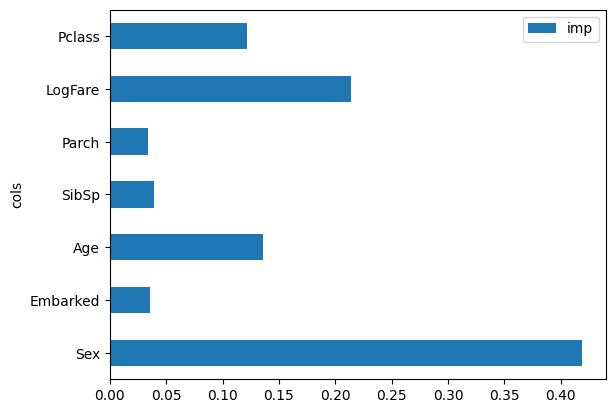

In [52]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh')